<a href="https://colab.research.google.com/github/yemanzhongting/2019_learning/blob/master/pltbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow

In [2]:
!pip install umap-learn

In [5]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups(subset='all')['data']

INFO:sklearn.datasets._twenty_newsgroups:Downloading 20news dataset. This may take a few minutes.
INFO:sklearn.datasets._twenty_newsgroups:Downloading dataset from https://ndownloader.figshare.com/files/5975967 (14 MB)




```!pip install sentence-transformers
# 此内容为代码格式
```

# 新段落

In [6]:
!pip install sentence-transformers

In [7]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar=True)

In [8]:
!pip install umap-learn

In [9]:
!mkdir -p drive
!google-drive-ocamlfuse drive

/bin/bash: google-drive-ocamlfuse: command not found


In [14]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15,n_components=5,metric='cosine').fit_transform(embeddings)

In [11]:
!pip install hdbscan

     |████████████████████████████████| 4.7MB 16.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.26-cp36-cp36m-linux_x86_64.whl size=2301710 sha256=a1ff0ae5df31b92b8a72455a63afe633a4c452b821ee449f75269449fb06a09c
  Stored in directory: /root/.cache/pip/wheels/82/38/41/372f034d8abd271ef7787a681e0a47fc05d472683a7eb088ed
Successfully built hdbscan


In [15]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

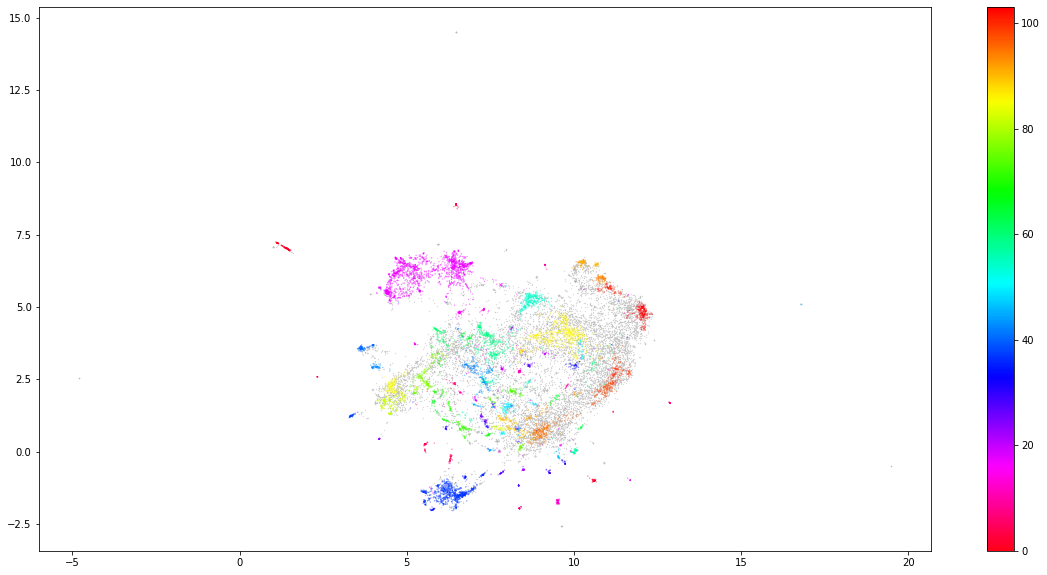

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
# plt.savefig('bert.jpg')
plt.colorbar()

In [18]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [19]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))


In [20]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)


,Topic,Size
0,-1,10537
18,17,1689
38,37,775
87,86,535
55,54,289
96,95,230
60,59,214
104,103,194
43,42,157
59,58,153


In [26]:
top_n_words

{-1: [('max', 0.0034175292191608053),
  ('use', 0.00228581228242543),
  ('windows', 0.0021758478295091483),
  ('does', 0.0020880599602861732),
  ('mail', 0.002078295609352001),
  ('used', 0.002076070902777427),
  ('file', 0.0020752323834356966),
  ('new', 0.0020525818183147766),
  ('software', 0.002042155296798155),
  ('computer', 0.002018277900153529),
  ('distribution', 0.0020043276441249276),
  ('time', 0.002001056418142996),
  ('information', 0.0019902232771298006),
  ('nntp', 0.00198922434351396),
  ('host', 0.001988383139080995),
  ('know', 0.001987351917671385),
  ('good', 0.0019663953422065436),
  ('need', 0.0019662143670767774),
  ('god', 0.001951558677488084),
  ('posting', 0.001946611195120009)],
 0: [('henrik', 0.1064672743689247),
  ('armenia', 0.07731316742116585),
  ('bm', 0.0605248616988727),
  ('planes', 0.059240959506762274),
  ('armenians', 0.05083250862178982),
  ('turkish', 0.04647605986296928),
  ('onur', 0.04580607728528309),
  ('yalcin', 0.04580607728528309),
  

In [22]:
 from sklearn.metrics.pairwise import cosine_similarity

In [23]:
for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,10537
14,13,1689
29,28,775
71,70,622
43,42,306
78,77,249
47,46,248
84,83,194
34,33,175
64,63,163


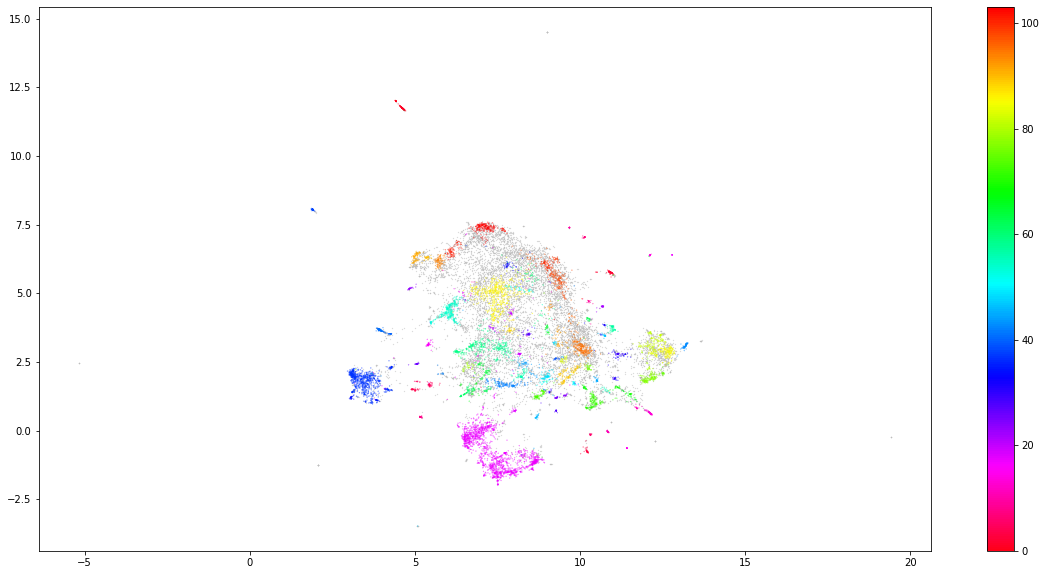

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.savefig('bert.jpg')
plt.colorbar()

In [25]:
!mkdir -p drive
!google-drive-ocamlfuse drive

/bin/bash: google-drive-ocamlfuse: command not found


In [28]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [31]:
!ls

bert.jpg  drive  gdrive  sample_data


In [33]:
!pwd

/content


In [32]:
import os
os.chdir("/gdrive/My Drive/Colab Notebooks/Hashing")

FileNotFoundError: ignored

# 新段落